In [2]:
import os
import pandas as pd
import json
from matplotlib import pyplot as plt

def get_screen_size(metadata_file_path):
    with open(metadata_file_path, 'r') as f:
        metadata = json.load(f)

        # Check if 'screenData' is a key in the metadata
        if 'screenData' in metadata:
            metadata = metadata['screenData']
        # Otherwise, assume the metadata is already at the top level

        screen_width = metadata.get('screenWidth')
        screen_height = metadata.get('screenHeight')

        if screen_width is None or screen_height is None:
            raise ValueError("Screen size not found in metadata")
        return screen_width, screen_height

# Define quadrant grid size
grid_size = 5

# Function to calculate the quadrant for a given point
def calculate_quadrant(x, y, width, height, grid_size):
    quadrant_x = int((x / width) * grid_size)
    quadrant_y = int((y / height) * grid_size)
    # Adjust for edge cases where the gaze point is at the exact maximum of the screen's width/height
    quadrant_x = min(quadrant_x, grid_size - 1)
    quadrant_y = min(quadrant_y, grid_size - 1)
    return quadrant_x, quadrant_y

In [3]:
def infer_dominant_quadrant(quadrant_counts, grid_size):
    max_count = -1
    dominant_quadrant = (0, 0)
    for y in range(grid_size):
        for x in range(grid_size):
            if quadrant_counts[y][x] > max_count:
                max_count = quadrant_counts[y][x]
                dominant_quadrant = (x, y)
    return dominant_quadrant

In [4]:
from PIL import Image
import os

def load_perfect_user_data(csv_file):
    perfect_user_data = []

    with open(csv_file, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split(',')

            # Extracting eye data
            left_pupil = (int(parts[3]), int(parts[4]))
            right_pupil = (int(parts[9]), int(parts[10]))
            
            # Store the eye data in a list
            perfect_user_data.append({
                'left_pupil': left_pupil,
                'right_pupil': right_pupil
            })

    return perfect_user_data

In [5]:
import numpy as np
def calculate_eye_data_similarity(current_user_eye_data, perfect_user_eye_data):
    # Calculate the Euclidean distance between the current user's and perfect user's eye data
    return np.linalg.norm(np.array(current_user_eye_data) - np.array(perfect_user_eye_data))


In [12]:
def process_gaze_data_per_user(base_dir, grid_size, perfect_user_data):
    user_quadrant_data = {}
    perfect_user_eye_data = perfect_user_data
    print('Processing gaze data...')
    # Only look at immediate subdirectories of the base_dir
    for user_dir in next(os.walk(base_dir))[1]:
        print('Processing directory:', user_dir)
        full_user_dir = os.path.join(base_dir, user_dir)
        metadata_file_path = os.path.join(full_user_dir, 'metadata.json')
        
        if os.path.exists(metadata_file_path):
            screen_width, screen_height = get_screen_size(metadata_file_path)
            quadrant_counts = [[0 for _ in range(grid_size)] for _ in range(grid_size)]
            user_eye_data_similarity = []
            user_data = []

            for file in os.listdir(full_user_dir):
                if file.endswith('.csv'):
                    data_file_path = os.path.join(full_user_dir, file)
                    data = pd.read_csv(data_file_path, header=None, skiprows=1)
                    for index, row in data.iterrows():
                        if index < len(perfect_user_eye_data):
                            current_user_eye_data = (row[3], row[4], row[9], row[10])
                            perfect_entry = perfect_user_eye_data[index]
                            perfect_eye_data = (perfect_entry['left_pupil'][0], perfect_entry['left_pupil'][1], 
                                                perfect_entry['right_pupil'][0], perfect_entry['right_pupil'][1])
                            
                            similarity = calculate_eye_data_similarity(current_user_eye_data, perfect_eye_data)
                            user_eye_data_similarity.append(similarity)

                            gaze_x = float(row[1])
                            gaze_y = float(row[2])
                            qx, qy = calculate_quadrant(gaze_x, gaze_y, screen_width, screen_height, grid_size)
                            quadrant_counts[qy][qx] += 1
                            user_data.append({
                                'gaze_point': (gaze_x, gaze_y),
                                'actual_quadrant': (qx, qy),
                                'similarity': similarity
                            })

            # Infer the dominant quadrant after processing all entries
            dominated_quadrant = infer_dominant_quadrant(quadrant_counts, grid_size)
            for entry in user_data:
                entry['claimed_quadrant'] = dominated_quadrant
                entry['is_within_threshold'] = entry['similarity'] <= 100  # Define a threshold value
            user_quadrant_data[user_dir] = user_data
        else:
            print(f"Metadata file not found for user {user_dir}")

    return user_quadrant_data

In [13]:
base_dir = 'data'
grid_size = 5
perfect_user_data_path = 'data/William/eye_gaze_data.csv'
perfect_user_data = load_perfect_user_data(perfect_user_data_path)
user_quadrant_data = process_gaze_data_per_user(base_dir, grid_size, perfect_user_data)


Processing gaze data...
Processing directory: eloise
Processing directory: Hossein
Processing directory: koala
Processing directory: melissa
Processing directory: muzzy
Processing directory: Naia
Processing directory: PerfectUser
Processing directory: Shaq
Processing directory: Will
Processing directory: William
Processing directory: WilliamOld


In [14]:
user_quadrant_data['Will']

[{'gaze_point': (20.0, 940.0),
  'actual_quadrant': (0, 4),
  'similarity': 65.00769185258002,
  'claimed_quadrant': (0, 4),
  'is_within_threshold': True},
 {'gaze_point': (1687.0, 20.0),
  'actual_quadrant': (4, 0),
  'similarity': 73.87827826905551,
  'claimed_quadrant': (0, 4),
  'is_within_threshold': True},
 {'gaze_point': (1687.0, 940.0),
  'actual_quadrant': (4, 4),
  'similarity': 33.37663853655727,
  'claimed_quadrant': (0, 4),
  'is_within_threshold': True},
 {'gaze_point': (228.0, 135.0),
  'actual_quadrant': (0, 0),
  'similarity': 64.66838485689897,
  'claimed_quadrant': (0, 4),
  'is_within_threshold': True},
 {'gaze_point': (228.0, 250.0),
  'actual_quadrant': (0, 1),
  'similarity': 44.15880433163923,
  'claimed_quadrant': (0, 4),
  'is_within_threshold': True},
 {'gaze_point': (228.0, 365.0),
  'actual_quadrant': (0, 1),
  'similarity': 64.59102104782058,
  'claimed_quadrant': (0, 4),
  'is_within_threshold': True},
 {'gaze_point': (228.0, 480.0),
  'actual_quadrant':

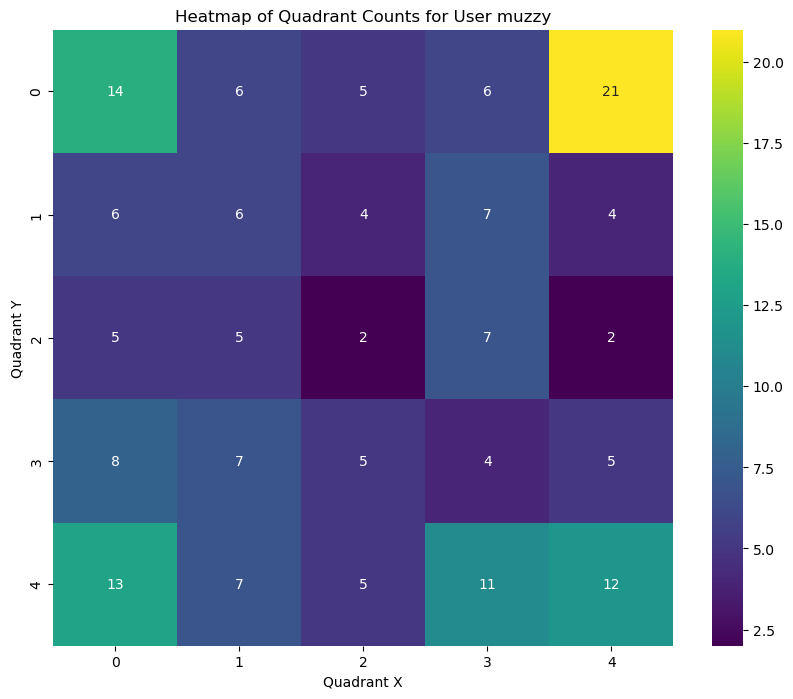

In [19]:
import seaborn as sns

def plot_heatmap(quadrant_counts, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(quadrant_counts, annot=True, fmt="d", cmap='viridis')
    plt.title(title)
    plt.xlabel('Quadrant X')
    plt.ylabel('Quadrant Y')
    plt.show()

def get_quadrant_counts(user_data, grid_size):
    quadrant_counts = [[0 for _ in range(grid_size)] for _ in range(grid_size)]
    for data in user_data:
        qx, qy = data['actual_quadrant']
        quadrant_counts[qy][qx] += 1
    return quadrant_counts

user_name = 'muzzy'  # Replace with the actual user's name you're interested in
if user_name in user_quadrant_data:
    user_data = user_quadrant_data[user_name]
    quadrant_counts_for_user = get_quadrant_counts(user_data, grid_size)
    plot_heatmap(quadrant_counts_for_user, f'Heatmap of Quadrant Counts for User {user_name}')
else:
    print(f"No data available for user {user_name}")



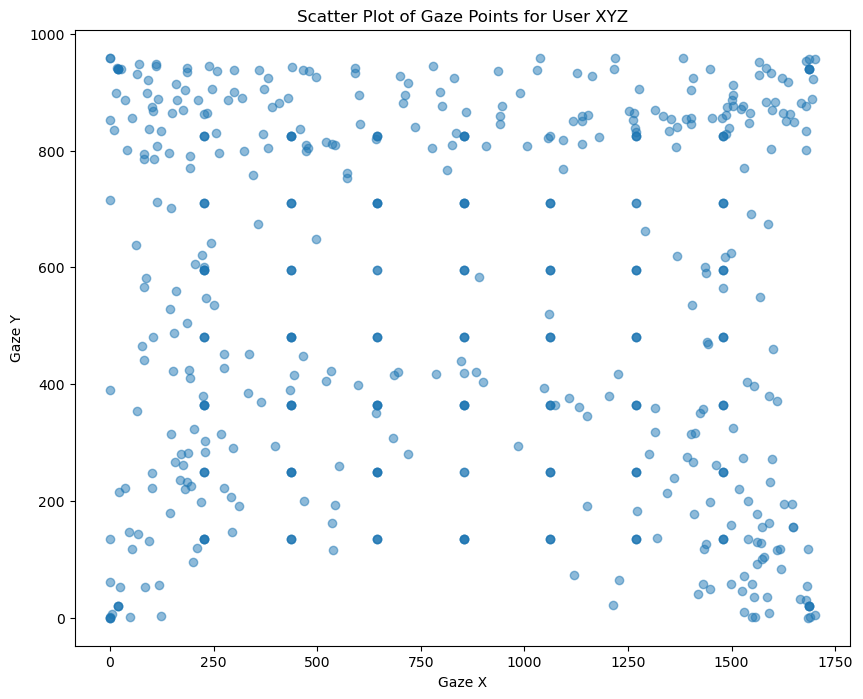

In [15]:
def plot_gaze_points(user_data, title):
    x = [point['gaze_point'][0] for point in user_data]
    y = [point['gaze_point'][1] for point in user_data]

    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, alpha=0.5)
    plt.title(title)
    plt.xlabel('Gaze X')
    plt.ylabel('Gaze Y')
    plt.show()

# Example of usage
user_data_for_a_user = user_quadrant_data['Will']
plot_gaze_points(user_data_for_a_user, 'Scatter Plot of Gaze Points for User XYZ')


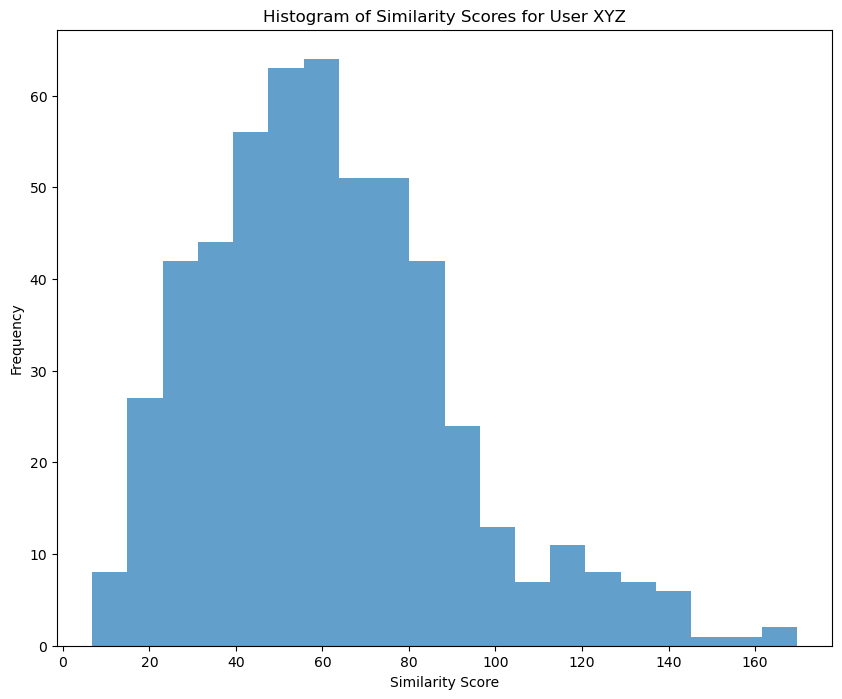

In [16]:
def plot_similarity_histogram(user_data, title):
    similarities = [entry['similarity'] for entry in user_data]

    plt.figure(figsize=(10, 8))
    plt.hist(similarities, bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.show()

# Example of usage
plot_similarity_histogram(user_data_for_a_user, 'Histogram of Similarity Scores for User XYZ')
